# NLP with Disaster Tweets

## Detecting Disasters: Using BERT for NLP Separate Forest Fires from “Fire" Shoes

#### Alexander Bricken

---

### Project Goals:
- Explore typical data science and machine learning practices by doing the following:
    - Importing data
    - Exploring data
    - Cleaning data
    - Preparing data
    - Setting up a train-test split
    - Running a machine learning model
- Apply specific NLP data preparation techniques
    - Feature engineering by creating meta-features
    - Text cleaning in a simple way using tokenization
    - Text cleaning more efficiently using GloVe embedding
- Apply BERT, a state-of-the-art language model for NLP
    

### Table Of Contents

1. Import Libraries
2. Import Data
3. Data Exploration
4. Data Preparation
5. Calculating Meta-Features
6. Text Cleaning
7. Machine Learning
8. Preparing Kaggle Submission

---

### Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import feature_extraction, preprocessing, linear_model, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from pandas_profiling import ProfileReport
import scikitplot as skplt
import string
import random
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_theme(style="whitegrid")

### Import Data

In [2]:
raw_test_data = pd.read_csv("../data/raw/test.csv")
raw_train_data = pd.read_csv("../data/raw/train.csv")

In [3]:
raw_train_data

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

### Data Exploration

We use PandasProfiling, a convenient library for data exploration.

In [4]:
profile = ProfileReport(raw_train_data, title="Pandas Profiling Report")

In [5]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

By using Pandas Profiling we can check through some essential features of the dataset:
- Class distribution of target variable in the train dataset. This is a 4342 (0), 3271 (1) split. This near equal separation is ok for training our model.
- Missing data. We see that the `location` and `keyword` columns contain missing data. This will be handled below.
- Cardinality. Our `location` values are particularly distinct. This is also dicussed and handled below.

### Data Preparation

`location` and `keyword` contain null values, as demonstrated by the pandas profiling report.

In [6]:
foo = [(raw_train_data[['keyword', 'location']].isnull().sum().values, raw_test_data[['keyword', 'location']].isnull().sum().values)]
out = np.concatenate(foo).ravel()

In [7]:
null_counts = pd.DataFrame({"column": ['keyword', 'location', 'keyword', 'location'],
                           "label": ['train', 'train', 'test', 'test'],
                           "count": out})

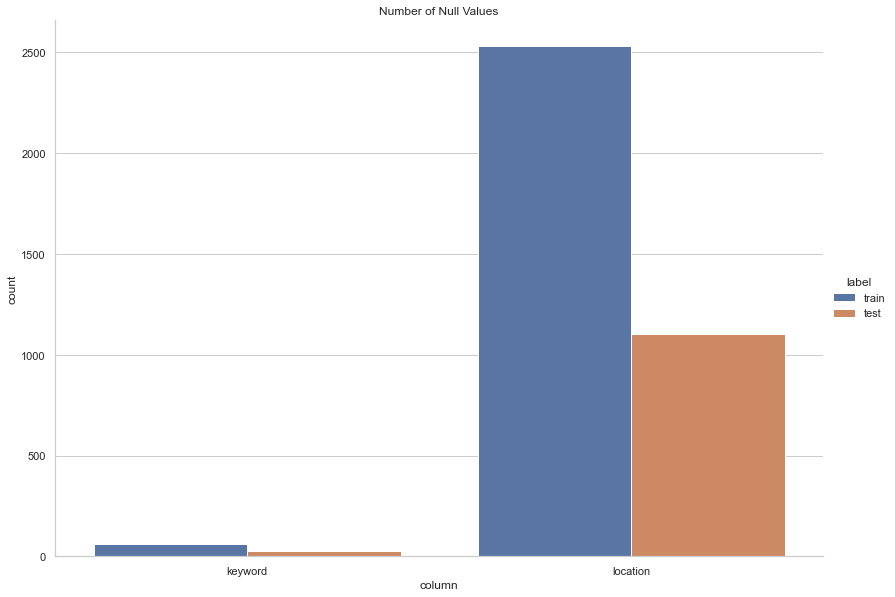

In [8]:
sns.catplot(x="column", y="count", data=null_counts, hue="label", kind="bar", height=8.27, aspect=11.7/8.27)
plt.title('Number of Null Values')
plt.show()

Locations from Twitter are user-populated and are thus too arbitrary. There are too many unique values and no standardization of input. We can remove this feature.

In [9]:
clean_train_data = raw_train_data.drop(columns="location")
clean_test_data = raw_test_data.drop(columns="location")

Keywords, on the other hand, are interesting to consider as a way of identifying disaster. This is because some keywords really are only used in a certain context.

What do our keywords look like? We can output wordclouds for our train and test datasets to examine this.

In [10]:
# set up stopwords (like the, and, but etc.)
stopwords = set(STOPWORDS)
stopwords.update(["nan"])

222 unique words in the keyword column for train data.


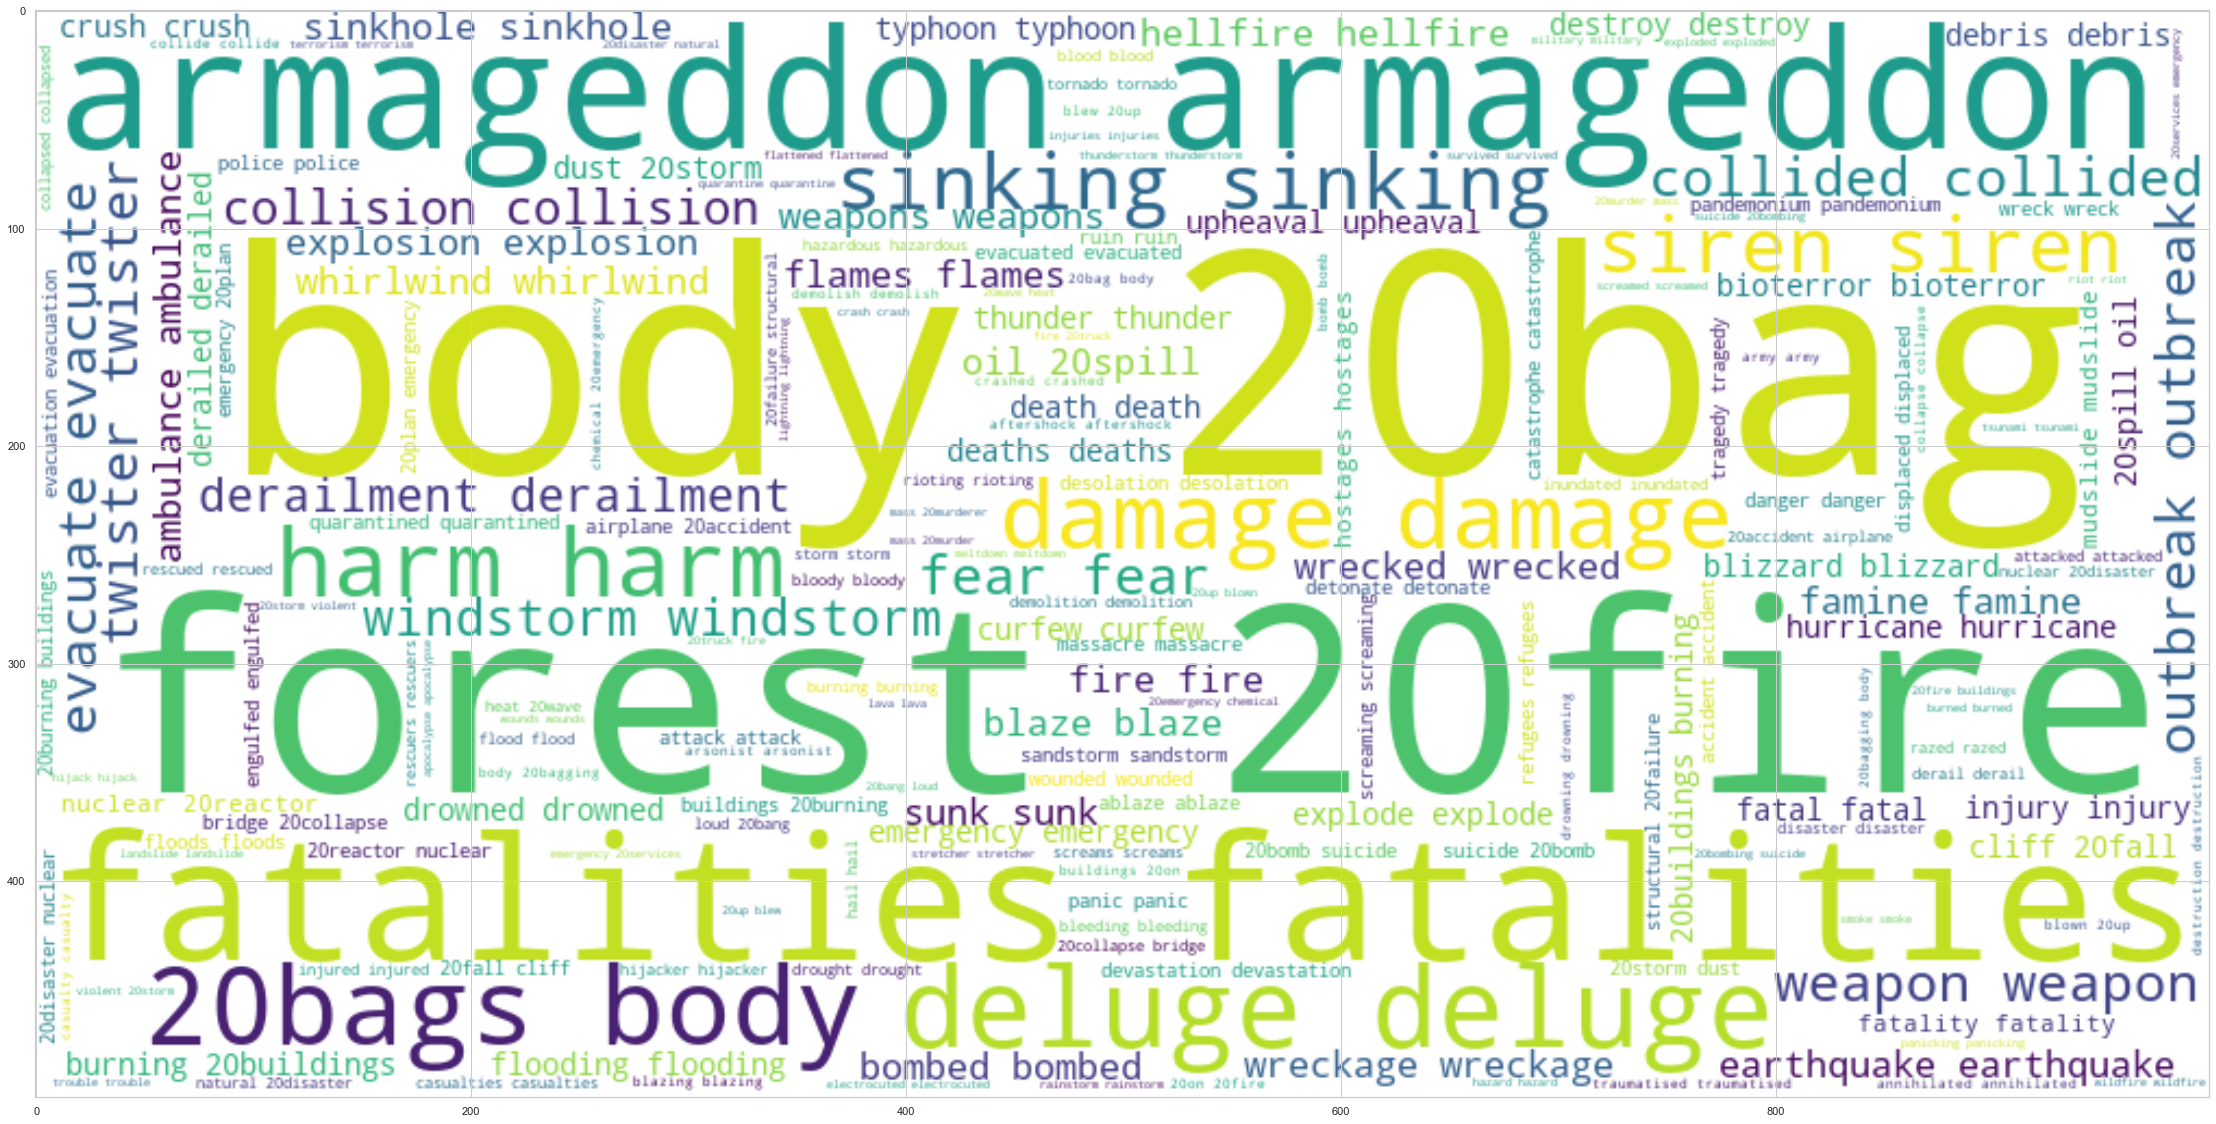

In [11]:
# for train
text = " ".join(word for word in clean_train_data['keyword'].astype(str))
print(f"{len(set(text.split()))} unique words in the keyword column for train data.")
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

222 unique words in the keyword column for test data.


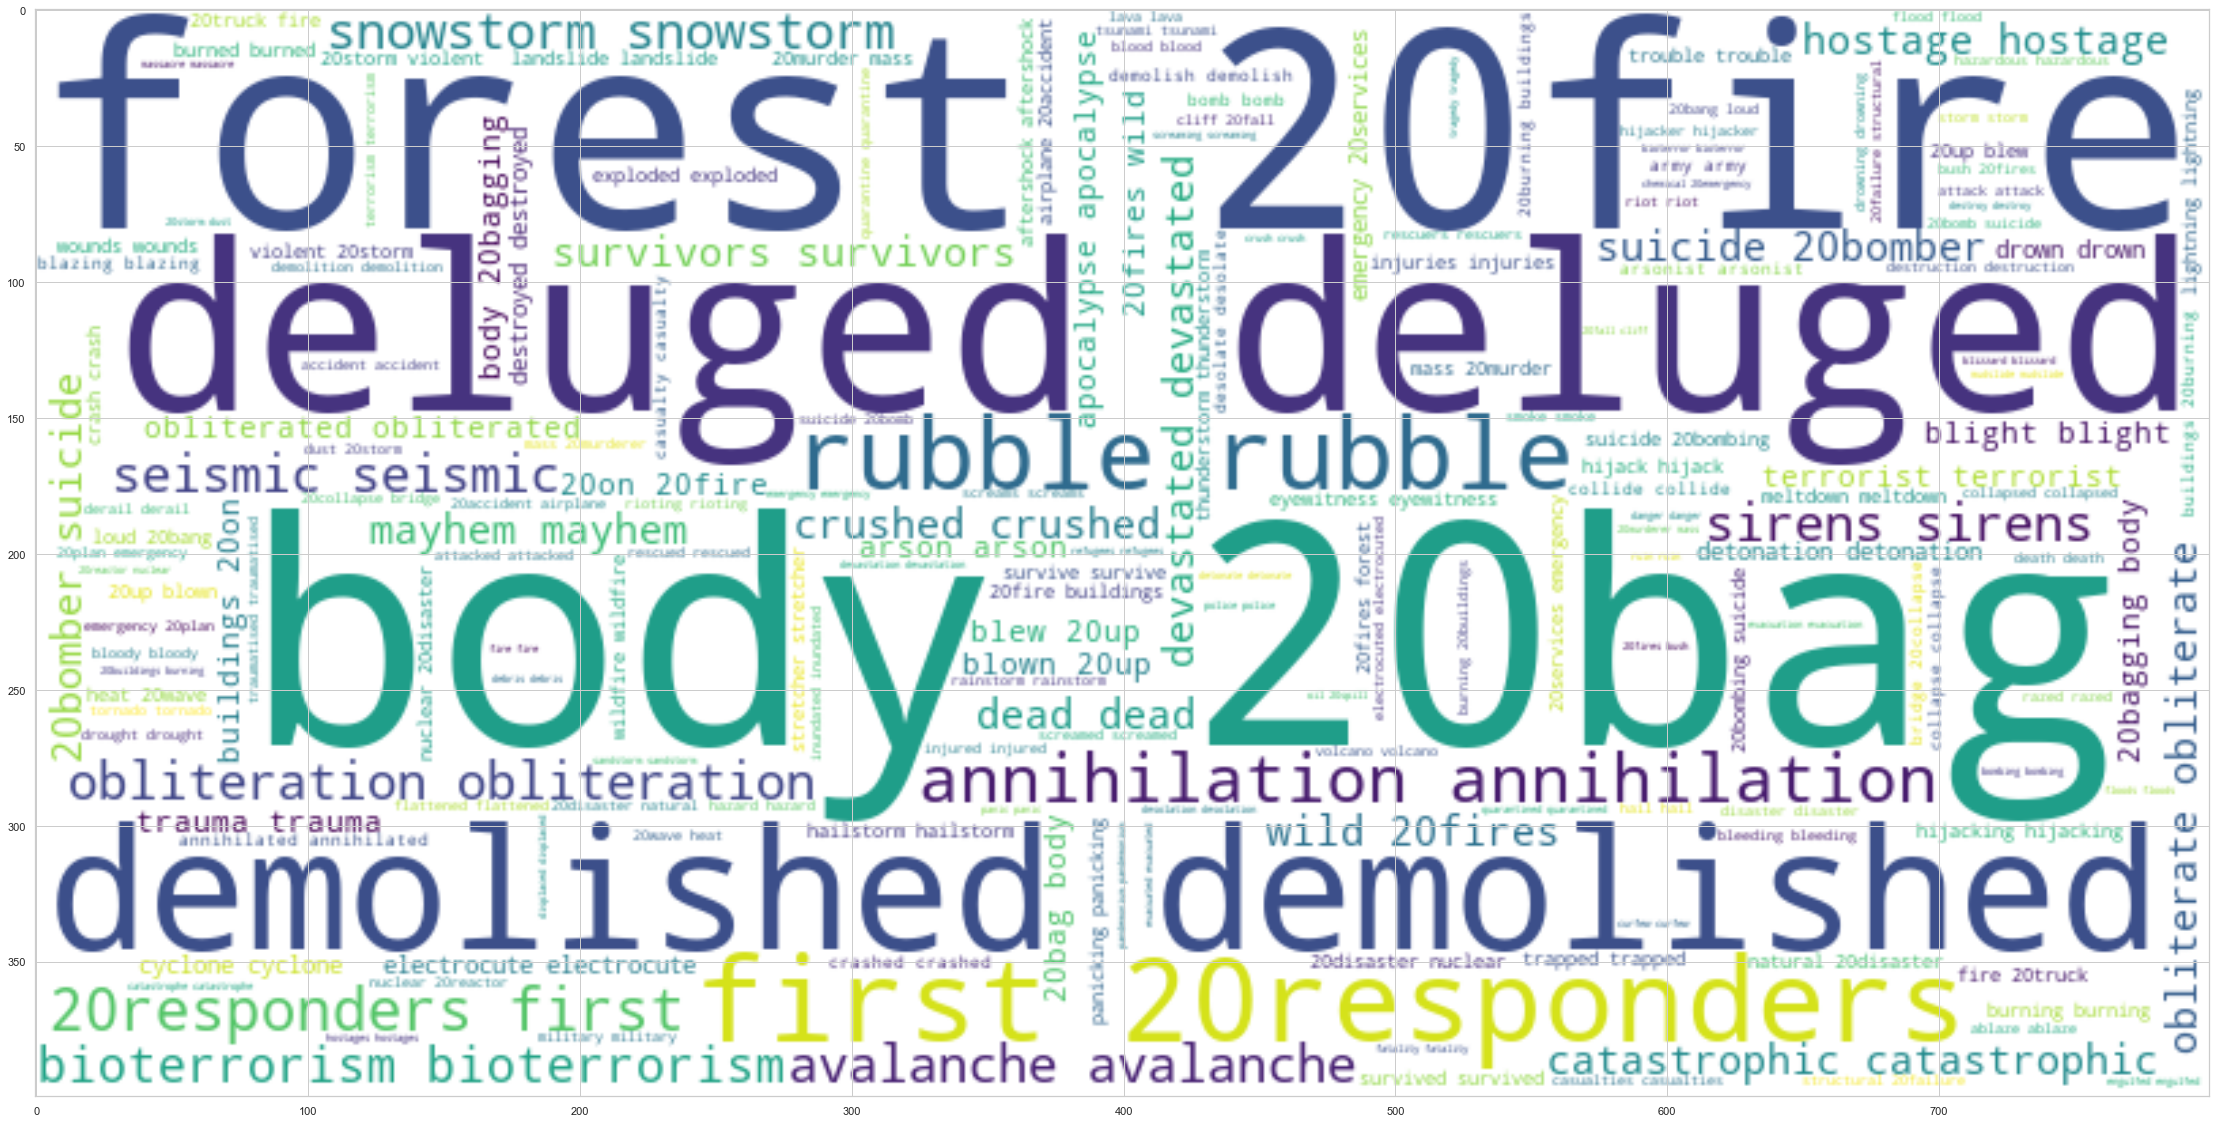

In [12]:
# for test
text = " ".join(word for word in clean_test_data['keyword'].astype(str))
print(f"{len(set(text.split()))} unique words in the keyword column for test data.")
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

We see that there is a good level of overlap between the keywords in treatment and control. Keyword is just one way of looking at the data, and if we just examine keywords there is not enough context to generate accurate predictions. The best way to use the keyword is to append each keyword to the end of Tweet. That way, we increase the weight of a keyword used, and thus don't need to drop or impute the null keyword columns (because those will just add nothing to the end).

In [13]:
# add keyword to end of text for train and test data
keyword_list_train = list(clean_train_data['keyword'])
keyword_list_test = list(clean_test_data['keyword'])
key_list_train = ['' if (type(i) == float and np.isnan(i)) else i for i in keyword_list_train]
key_list_test = ['' if (type(i) == float and np.isnan(i)) else i for i in keyword_list_test]
text_list_train = list(clean_train_data['text'])
text_list_test = list(clean_test_data['text'])

# iterate through and add to end, with space in-between
for i in range(len(clean_train_data['keyword'])):
    text_list_train[i] = text_list_train[i] + ' ' + key_list_train[i]

for i in range(len(clean_test_data['keyword'])):
    text_list_test[i] = text_list_test[i] + ' ' + key_list_test[i]

In [14]:
# relabel text
clean_train_data['text'] = text_list_train
clean_test_data['text'] = text_list_test

In [15]:
# drop keyword col
clean_train_data = clean_train_data.drop(columns='keyword')
clean_test_data = clean_test_data.drop(columns='keyword')

In [16]:
# output as check
clean_train_data.head()

id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4            Forest fire near La Ronge Sask. Canada        1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

Finally, it is worth checking for duplicates.

In [17]:
# check for duplicates using groupby
df_nondupes = clean_train_data.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_dupes = df_nondupes[df_nondupes['target'] > 1]
df_dupes

id  target
text                                                          
Hellfire is surrounded by desires so be careful...   3       2
wowo--=== 12000 Nigerian refugees repatriated f...   2       2
In #islam saving a person is equal in reward to...   2       2
#foodscare #offers2go #NestleIndia slips into l...   3       2
Who is bringing the tornadoes and floods. Who i...   3       2
To fight bioterrorism sir. bioterrorism              4       2
#Allah describes piling up #wealth thinking it ...   3       2
RT NotExplained: The only known image of infamo...   2       2
Hellfire! We donÛªt even want to think about i...   2       2
CLEARED:incident with injury:I-495  inner loop ...   3       2
.POTUS #StrategicPatience is a strategy for #Ge...   4       2
He came to a land which was engulfed in tribal ...   6       2
The Prophet (peace be upon him) said 'Save your...   6       2
that horrible sinking feeling when youÛªve bee...   4       2
Caution: breathing may be hazardous to your hea...   2       2

If we iterate through these duplicates we can individually label them by hand so we keep the data. This is necessary because some of them are mislabeled, as per the sum of the targets against the sum of the IDs, as seen above.

In [18]:
# take index which is the texts themselves
dupe_text_list = df_dupes.index
dupe_text_list = list(dupe_text_list) # turn into list

# manually make label list to iterate
right_labels = [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]

In [19]:
# drop duplicates except for one
clean_train_data = clean_train_data.drop_duplicates(subset=['text'], keep='last').reset_index(drop=True)

In [20]:
# relabel duplicate rows
for i in range(len(dupe_text_list)):
    clean_train_data.loc[clean_train_data['text'] == dupe_text_list[i], 'target'] = right_labels[i]

### Calculating Meta-Features

We need ways to learn more about our data and separate it out into additional features. By thinking about different variables we can generate that might help us distinguish disasters from non-disasters, we can train our model on more features. This will provide more visibility for our model. The best way to think about Tweets indicating disaster are that they are likely from higher quality sources that are more serious in nature. Thus, following stricter grammatical rules, fully reporting on the situation, and sharing links.

- `num_hashtags` count of hashtags (#) (hypothesis (H): hashtags are used by normal users rather than new agencies)
- `num_mentions` count of mentions (@) (H: more tags could be used by normal users rather than news agencies)
- `num_words` count of words (H: more words in proper reports on Twitter than normal user tweets)
- `num_stop_words` number of stop words (H: more stop words used via proper grammar from news agencies)
- `num_urls` count of urls (H: urls shared by news agencies reporting disaster more often than not)
- `avg_word_length` average character count in words (H: longer words that aren't abbreviated used by news agencies)
- `num_chars` count of characters (H: more characters used in news agency tweets to report full story)
- `num_punctuation` count of punctuations (H: more punctuation in news agency tweets following correct grammar)

We generate these new columns below.

In [21]:
### num_hashtags
clean_train_data['num_hashtags'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
clean_test_data['num_hashtags'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

### num_mentions
clean_train_data['num_mentions'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
clean_test_data['num_mentions'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

### num_words
clean_train_data['num_words'] = clean_train_data['text'].apply(lambda x: len(str(x).split()))
clean_test_data['num_words'] = clean_test_data['text'].apply(lambda x: len(str(x).split()))

### num_stop_words
clean_train_data['num_stop_words'] = clean_train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
clean_test_data['num_stop_words'] = clean_test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

### num_urls
clean_train_data['num_urls'] = clean_train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
clean_test_data['num_urls'] = clean_test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

### avg_word_length
clean_train_data['avg_word_length'] = clean_train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_test_data['avg_word_length'] = clean_test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

### num_chars
clean_train_data['num_chars'] = clean_train_data['text'].apply(lambda x: len(str(x)))
clean_test_data['num_chars'] = clean_test_data['text'].apply(lambda x: len(str(x)))

### num_punctuation
clean_train_data['num_punctuation'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
clean_test_data['num_punctuation'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

### Text Cleaning

We need to make sure the tweets we using in our dataset are of a similar fashion. Particularly in the user-created Tweets, there could be plenty of typos, missing grammar, or abbreviations. 

To improve on the technique below, I will use embeddings to deal with the variation in text. However, for now I am doing some simple cleaning. I am curious about the difference in results with/without embedding.

By using our own embeddings, instead of pre-trained embeddings, we can get as close to the vocabulary used in our dataset as possible. Similar words are clustered in a high dimensional space by using am embedding Global Vectors for Word Representation (GloVe) technique.

#### Simple Text Cleaning

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbricken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
train_df = clean_train_data.copy()
test_df = clean_test_data.copy()

In [31]:
# function taken from https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76

def simple_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    # then remove stop words (all encoded in meta features)
    x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # then remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    # then use regex to remove mentions, hashtags, and links (all of this is encoded in meta features)
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'@\S+', ' ', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x

In [32]:
train_df['cleaned_text'] = train_df.text.apply(simple_text_clean)
test_df['cleaned_text'] = test_df.text.apply(simple_text_clean)

#### Embedded Text Cleaning

In [33]:
### STILL TO BE DONE

### Machine Learning

To start with, I train a simple convolutional neural network and submit my predictions. This is to test if my feature engineering has worked.

I perform tokenization here as a basic way of including the data of my text into the machine learning model alongside my meta-features.

Tokenization separates a piece of text into tokens. These tokens are words. It allows the text data to be turned into numbers that the machine learning model can read. We use a vocabulary size of 10000 here to make it extremely broad to start with. Eventually, we may want to lower this to deal with OOV (Out Of Vocabulary) words more appropriately. However, when we do GloVe embedding this problem will be solved for.

**TODO: expand metafeatures using one-hot encoding to make them less relevant in model.**

#### Basic Machine Learning Using Tokenization

In [34]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

In [35]:
# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']
# from no text
train_no_text_df = final_train_df.drop(columns='cleaned_text')
test_no_text_df = final_test_df.drop(columns='cleaned_text')

In [38]:
features = test_no_text_df.columns

In [39]:
# normalise columns
scaler = MinMaxScaler()
train_no_text_df[features] = scaler.fit_transform(train_no_text_df[features])
test_no_text_df[features] = scaler.fit_transform(test_no_text_df[features])

In [40]:
vocab_size = 10000
oov_tok = '<OOV>'
embedding_dim = 32
trunc_type = 'pre'
padding_type = 'pre'
max_length = 100

In [41]:
# tokenization of train texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [42]:
# tokenization of test texts
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [43]:
train_padded_val_df = pd.DataFrame(train_padded)
test_padded_val_df = pd.DataFrame(test_padded)

# add to df
tokenized_train_df = pd.concat([train_no_text_df, train_padded_val_df], axis=1, join="inner")
tokenized_test_df = pd.concat([test_no_text_df, test_padded_val_df], axis=1, join="inner")

In [44]:
# extract labels
train_labels = tokenized_train_df['target']
tokenized_x = tokenized_train_df.drop(columns='target')

In [45]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(tokenized_x, train_labels, test_size=0.3, random_state=42)

In [46]:
# create generic CNN
# i will modify the layers of this later
model_conv = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.2),
    Conv1D(128, 7, activation='relu'),
    GlobalMaxPool1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# compile and summarise
model_conv.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_conv.summary()

# first fit is history1
history1 = model_conv.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 128)           28800     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [47]:
# predictions
test_pred = model_conv.predict(tokenized_test_df)
print(test_pred)
# this is the probabilities of each row being not disastrous (0) or disaster (1)

[[0.8786702 ]
 [0.16634667]
 [0.9963583 ]
 ...
 [0.7781023 ]
 [0.99650306]
 [0.96218455]]


### Preparing Kaggle Submission

All we need to do now is turn our output probabilities of our machine learning model into boolean values and submit the predictions!

In [48]:
# this checks if the probability of disaster is above 0.5. If so, we label 1.
test_pred_bool = test_pred.copy().astype(int)
for index in range(len(test_pred)): 
    if test_pred[index]>0.5:
        test_pred_bool[index]=1
    else:
        test_pred_bool[index]=0

In [49]:
final_predictions = test_pred_bool.flatten()

In [50]:
submission = pd.read_csv("../data/submissions/submission.csv")

In [51]:
submission["target"] = final_predictions

In [52]:
submission.to_csv('submission1.csv', index=False)

In [303]:
submission

id  target
0         0       1
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]

To submit, we use the Kaggle API and type the following:

`kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"`

#### BERT Modelling (to be further explored soon)

In [173]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

In [174]:
def build_model(bert_layer, max_seq_len, lr):
        
    input_word_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_seq_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name='segment_ids')    

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])   
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    optimizer = SGD(learning_rate=lr, momentum=0.8)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
all_tokens = []
all_masks = []
all_segments = []

for text in texts:
    text = self.tokenizer.tokenize(text)
    text = text[:self.max_seq_length - 2]
    input_sequence = ['[CLS]'] + text + ['[SEP]']
    pad_len = self.max_seq_length - len(input_sequence)

    tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
    tokens += [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * self.max_seq_length

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
y_trn = X.loc[trn_idx, 'target_relabeled']
X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
y_val = X.loc[val_idx, 'target_relabeled']

In [181]:
# Model
model = build_model(bert_layer, max_seq_len=128, lr=0.0001)        
model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=10, batch_size=32)

NameError: name 'X_trn_encoded' is not defined

In [156]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_layer(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * ['this is such an amazing movie!']
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')}
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
    * True
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask')}
    * False
    * None
  Keyword arguments: {}

#### Additional Machine Learning Tests

In [181]:
# testing a support vector machine

# because I haven't done any NLP, I will just use random data with my labels.

y_true = clean_train_data['target']
x1 = np.random.random_sample(len(y_true))
x2 = np.random.random_sample(len(y_true))
xs = list(zip(x1,x2))

In [182]:
X_train, X_test, y_train, y_test = train_test_split(xs, y_true, test_size=0.3, random_state=42)

In [183]:
clf = SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

In [184]:
y_pred = clf.predict(X_test)
y_probas = clf.predict_proba(X_test)

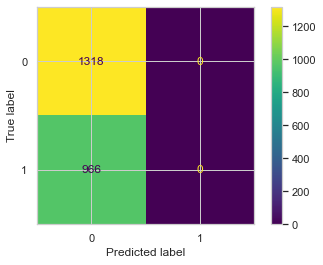

In [185]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()  

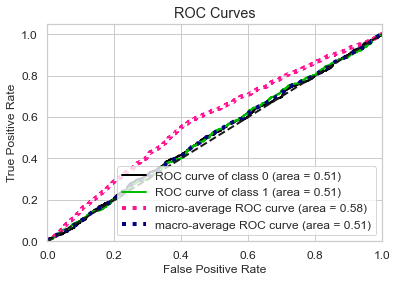

In [186]:
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [187]:
print(classification_report(y_test, y_pred, target_names=["not disaster", "disaster"]))

              precision    recall  f1-score   support

not disaster       0.58      1.00      0.73      1318
    disaster       0.00      0.00      0.00       966

    accuracy                           0.58      2284
   macro avg       0.29      0.50      0.37      2284
weighted avg       0.33      0.58      0.42      2284



/usr/local/Caskroom/miniconda/base/envs/pygen/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/pygen/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/pygen/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera